In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
import imageio
from tqdm import tqdm

In [ ]:
!wget https://248006.selcdn.ru/main/upload/setka_images/08234924102020_395ac55f9d2bdf7b2eaa249aca1918774fc91ed3.jpg -O pattern.jpg

--2021-12-08 18:06:38--  https://248006.selcdn.ru/main/upload/setka_images/08234924102020_395ac55f9d2bdf7b2eaa249aca1918774fc91ed3.jpg
Resolving 248006.selcdn.ru (248006.selcdn.ru)... 92.53.68.202, 92.53.68.205, 92.53.68.203, ...
Connecting to 248006.selcdn.ru (248006.selcdn.ru)|92.53.68.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158406 (155K) [image/jpeg]
Saving to: ‘pattern.jpg’

pattern.jpg         100%[===================>] 154.69K   662KB/s    in 0.2s    

2021-12-08 18:06:39 (662 KB/s) - ‘pattern.jpg’ saved [158406/158406]



In [ ]:
class ImageCompressor:
  def __init__(self, level=0.5, chunk_size=8):
    self.level = 0.5
    self.chunk_size = 8

  def __dct2(self, x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

  def __idct2(self, x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

  def __compress_layer(self, layer):
    chunks = self.__to_chunks(layer)
    with tqdm(total=chunks.size, position=0, leave=True) as pbar:
      for i in range(chunks.shape[0]):
        for j in range(chunks.shape[1]):
          chunks[i][j] = self.__compress_chunk(chunks[i][j]).reshape(chunks[i][j].shape[1], chunks[i][j].shape[0]).T
          pbar.update(1)
    return self.__from_chunks(chunks)
  
  def __decompress_layer(self, layer):
    chunks = self.__to_chunks(layer)
    
    with tqdm(total=chunks.size, position=0, leave=True) as pbar:
      for i in range(chunks.shape[0]):
        for j in range(chunks.shape[1]):
          chunks[i][j] = self.__decompress_chunk(chunks[i][j])
          pbar.update(1)
    image = self.__from_chunks(chunks)
    return image

  def __decompress_chunk(self, chunk):
    Xa = self.__idct2(chunk)
    return np.array(Xa)

  def __compress_chunk(self, X):
    X = X / 255
    ny, nx = X.shape
    # extract small sample of signal
    k = round(nx * ny * self.level) # 50% sample
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
    b = X.T.flat[ri]
    b = np.expand_dims(b, axis=1)

    # create dct matrix operator using kron (memory errors for large ny*nx)
    A = np.kron(
        spfft.idct(np.identity(nx), norm='ortho', axis=0),
        spfft.idct(np.identity(ny), norm='ortho', axis=0)
        )
    A = A[ri,:] # same as phi times kron

    # do L1 optimization
    vx = cvx.Variable(nx * ny)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    b = b[:, 0]
    prob = cvx.Problem(objective, [A * vx == b])
    result = prob.solve()
    Xat2 = np.array(vx.value).squeeze()
    return Xat2

  def __to_chunks(self, layer):
    ny, nx = layer.shape
    rows = []
    for i in range(0, ny, self.chunk_size):
      rows.append(layer[i:i + self.chunk_size, :])
    chunks = [[] for i in range(len(rows))]

    for i in range(len(rows)):
      for j in range(0, nx, self.chunk_size):
        chunks[i].append(rows[i][:, j:j + self.chunk_size])
    return np.array(chunks)

  def __from_chunks(self, chunks):
    rows = []
    for i in range(chunks.shape[0]):
      row = np.concatenate(chunks[i], axis=1)
      rows.append(row)
    return np.concatenate(np.array(rows), axis=0)

  def compress(self, img):
    """
    This method compresses image considering it as a standard RGB.
    """
    n_layers = img.shape[2]
    layers = [img[:, :, layer] for layer in range(n_layers)]
    compressed_layers = [np.expand_dims(self.__compress_layer(layer), axis=2) for layer in layers]
    return np.concatenate(np.array(compressed_layers), axis=2)
  
  def decompress(self, img):
    n_layers = img.shape[2]
    layers = [img[:, :, layer] for layer in range(n_layers)]
    decompressed_layers = [np.expand_dims(self.__decompress_layer(layer), axis=2) for layer in layers]
    return np.concatenate(np.array(decompressed_layers), axis=2)


In [ ]:
# read original image and downsize for speed
Xorig = imageio.imread('pattern.jpg')
print(Xorig.shape[2])
comp = ImageCompressor(level=0.8)
compressed = comp.compress(Xorig)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


3


100%|██████████| 10000/10000 [01:44<00:00, 95.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 10000/10000 [01:43<00:00, 96.54it/s] 


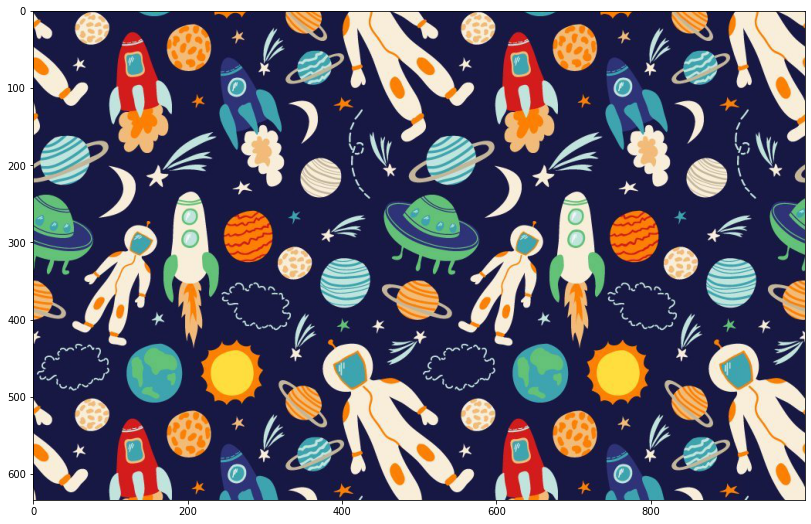

In [ ]:
plt.figure(figsize=(16, 9))
plt.imshow(Xorig)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


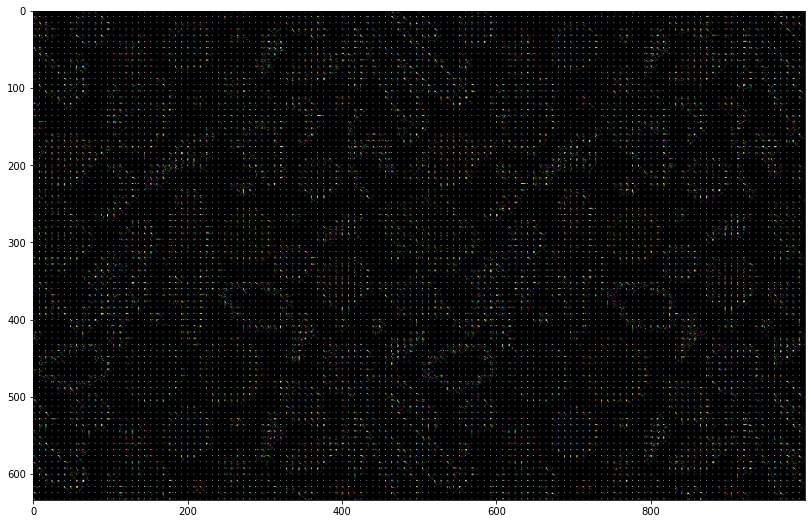

In [ ]:
plt.figure(figsize=(16, 9))
plt.imshow(compressed)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 10000/10000 [00:00<00:00, 42354.77it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 10000/10000 [00:00<00:00, 50936.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


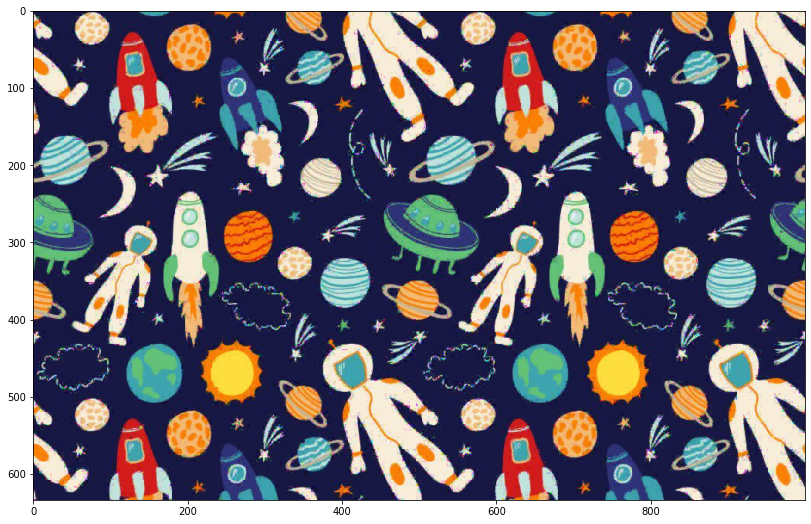

In [ ]:
plt.figure(figsize=(16, 9))
plt.imshow(comp.decompress(compressed))
plt.show()